# Neural Network

## Introduction

An artificial Neural Network (NN) is a computational model to approximate complex, non-linear functions. Given a set of inputs $x$, and some internal parameters $\omega$, the NN produces the corresponding outputs 
$y = f\left(x; \omega \right)$. The NN is just a clever way of writing $f$, inspired by the structure of biological brains. The simplest form is the feed-forward NN sketched below:
<table>
<tr><td>
<img src="images/nnscheme.png" width="400px">
</td></tr>
<tr><td>
Schematic representation of a feed forward neural network.
</td></tr>
</table>

The input values are fed to a layer of simple computational units, called <i>neurons</i>, which combine them with the parameters $\omega$ to calculate their <i>activation</i> output. These values are then sent to the neurons in the output layer, which, in the same way, compute the final output $y$.

Each $j$-th neuron in a layer computes its activation $a_j$ as:
<table>
<tr><td>
<img src="images/nnneuron.png" width="400px">
</td></tr>
<tr><td>
Neuron connection mechanism.
</td></tr>
</table>

The parameters $\omega_{j,i}$ are connection weights, while $b_j$ are internal neuron biases. All of these parameters make up the NN parameter set $\omega$.
The activation function $S$ is arbitrary, as long as it is non-linear. 
Most common activation functions are hyperbolic tangent and rectified linear unit (ReLU). 
In some cases, the activation function of output neurons is just linear (weighted sum of inputs).


## Example

Here we use a NN to approximate an analytical function, called Model. In reality we wouldn't know the analytical expression for this function, just its values at some reference points. The knowledge can be exploited to train a neural network that mimics the original function.

In [5]:
# --- INITIAL DEFINITIONS ---

from sklearn.neural_network import MLPRegressor
import numpy, math, random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# This function takes a 2-element vector p=[x,y] and computes z
def Model(p):
    result = math.sin(0.4*p[0] - 0.3*p[1] + 0.2*p[0]*p[1])
    result += (2*random.random()-1)*0.1;
    return result


This is the model function that will approximate:
<img src="./images/nnsurface.png">
A small random noise is added to the function... to spice things up!

Now we use the function to create a database of reference points, divided into <i>training</i> and <i>validation</i> sets.

The training set provides the NN with a set of <i>examples</i> to learn from, while the validation set is later used to check the quality of the trained NN.
The following code creates a list of $\left(x,y\right)$ points on the real plane, with $x,y \in \left[-1,1 \right]$, to use as inputs.
By applying the Model function to each one, we get a list of corresponding output:

$z = \sin\left( 0.4x - 0.3y + 0.2xy \right) + \mathrm{noise}$

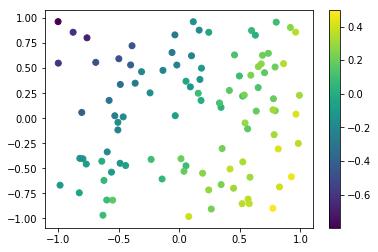

In [6]:
# training points
nTrainPts = 100
trainIn = 2*numpy.random.rand(nTrainPts,2) -1 # (x,y) points beween -1 and 1

# validation points
nValidPts = 40
validIn = 2*numpy.random.rand(nValidPts,2)-1 # (x,y) points beween -1 and 1
 
# apply Model to the points to compute z for the two sets
trainOut = numpy.apply_along_axis(Model, 1, trainIn)
validOut = numpy.apply_along_axis(Model, 1, validIn)

# visualise the training set
plt.scatter(trainIn[:,0], trainIn[:,1], c=trainOut[:])
plt.colorbar()
plt.show()

Next we create a NN suitable for this problem. 
We can start with one hidden layer, containing 10 neurons. Initially all NN parameters are random.

There are lots of initialisation parameters to chose from, and some may be important to train successfully.
Check the scikit-learn <a href="http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html">documentation</a> for a list of parameters and their meaning.


In [7]:
# setup the neural network - 10 hidden neurons in 1 layer
# the network uses tanh function on all hidden neurons
# alpha is a regularisation parameter, explained later
nn = MLPRegressor(hidden_layer_sizes=(10),  activation='tanh', solver='adam', alpha=0.01)

## Training
Now comes the tough part! 
The idea of training is to evaluate the NN on the training inputs and measure the error between its output and the reference values:

$$ E = \sum_{i}^{\mathrm{samples}} \left( y_i - y_i^{\mathrm{ref}} \right)^2$$

It is then possible to compute the derivative (gradient) of the error w.r.t. each parameter (connections and biases):

$$ \mathbf{G} = \frac{\partial E}{\partial \mathbf{\omega}} $$

By shifting the parameters in the opposite direction of the gradient, we obtain a better set of parameters, that should give smaller error. This procedure can be repeated until $E$ is minimised.

/home/hamid/ML-CSC-tutorial/env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean Abs Error (training)  : 0.07586428342706653
Mean Abs Error (validation): 0.08516905846638774


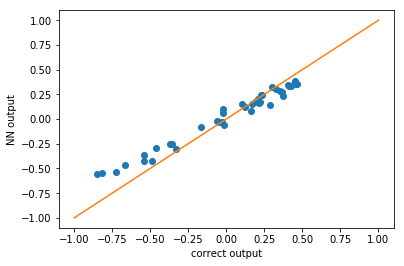

In [8]:
# some NN parameters can be changed here, without re-initialising the whole thing
#nn.set_params(learning_rate='adaptive', solver='lbfgs')
nn.fit(trainIn, trainOut);

# evaluate the training and validation error
trainMLOut = nn.predict(trainIn)
validMLOut = nn.predict(validIn)

print ("Mean Abs Error (training)  : " + str ((numpy.abs(trainMLOut-trainOut)).mean()))
print ("Mean Abs Error (validation): " + str ((numpy.abs(validMLOut-validOut)).mean()))

# make a nice plot
plt.plot(validOut,validMLOut,'o')
plt.plot([-1,1],[-1,1]) # perfect fit line
plt.xlabel('correct output')
plt.ylabel('NN output')
plt.show()

### Remarks: regularisation

When we created the NN we set its regularisation property <i>alpha</i>, without explaining it: here is what it's about!

In many cases, there are lots of neurons and thus parameters (complex model) but not a lot of data to train them. We might need such complex model for our purpose, but as a rule of thumb there should be at least 10 data points per parameter.

If not, we are most likely over-fitting the data, i.e. we get a NN that brilliantly fits the training points, but utterly fails in validation. This is analogous to fitting a bunch of linearly correlated $\left(x,y\right)$ points with a 1000-degree polynomial. The fit might go through all the points, but it has no predictive power!

Instead, we would like to train the NN to be as accurate <b>and</b> simple as possible, and one way to simplify a NN with lots of neurons is setting some useless connections to zero.

The complexity of the network $R$, or regularisation factor, can be estimated e.g. by the sum of squared parameters:

$$R = \sum_{i} \omega_i^2$$

and the quantity to minimise during training becomes:

$$ E + \alpha R = \sum_{i}^{\mathrm{samples}} \left( y_i - y_i^{\mathrm{ref}} \right)^2 + \alpha \sum_{i} \omega_i^2$$

The gradient of $R$ w.r.t. the parameters steers the training towards smaller weights at the expense of accuracy. One can chose how much the regularisation affects the training with the parameter <i>alpha</i>.